In [3]:
import pandas as pd
import numpy as np
import scipy.stats as scs

from impute_transform import ImputeTransform
from supervised_functions import *
from fancyimpute import *

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('ggplot')

/home/christie/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/holdout_data.csv')

# Supervised Learning in ADHD

## Introduction

The lab wanted to see which models were best for predicting ADHD diagnosis, and how significant the differences between them were.


To tackle this, I picked four classifier models:
 - Logistic Regression
 - Random Forest
 - Gradient Boosting
 - XGBoost
 
 
And examined ROC AUC and log loss scores on four datasets:
 - DX ~ All features (TMCQ + Neuropsych)
 - DXSUB ~ All features
 - DX ~ TMCQ features
 - DX ~ Neuropsych features

---

First, a bit of exploratory data analysis to decide how to impute values, and whether or not any of our variables are 'leaky'.

# EDA: Missing Value Imputation

Missing values are common in clinical research (e.g., the participant did not complete a task or missed a question on a survey) but impact data analysis. It is not appropriate to drop subjects with any missing data because that would limit our dataset. Single imputation, where you replace missing values on a variable with one specific value, is not a good option.

The Python library, [fancyimpute](https://pypi.python.org/pypi/fancyimpute), gives us some good options for dealing with this. The following section will explore which algorithm is the best option for this dataset.

In [53]:
# Make all solver objects
KNN_solver = KNN(k=5)
softimpute_solver = SoftImpute()
MICE_solver = MICE()
simple_solver = SimpleFill()
iterativeSVD_solver = IterativeSVD()
mf_solver = MatrixFactorization()

solver_list = [KNN_solver, softimpute_solver, MICE_solver,
               simple_solver, iterativeSVD_solver, mf_solver]
solver_names = ['KNN', 'SoftImpute', 'MICE', 'SimpleFill',
                   'IterativeSVD', 'MatrixFactorization']

In [54]:
# Create a dataframe from the complete data in `train_data`. Then, randomly insert some NaNs for MSE testing.
nan_inserted_data, missing_mask, complete_df = create_missing_data(train_data)

In [55]:
%%capture
mse_df = create_mse_df(nan_inserted_data, missing_mask,
                       complete_df, solver_list, solver_names)

Which method had the most "minimum MSEs" across the columns?

In [56]:
min_mse(mse_df, solver_names)

KNN Frequency of Minimum MSE:                     4 of 35 features
SoftImpute Frequency of Minimum MSE:              2 of 35 features
MICE Frequency of Minimum MSE:                    2 of 35 features
SimpleFill Frequency of Minimum MSE:              1 of 35 features
IterativeSVD Frequency of Minimum MSE:            3 of 35 features
MatrixFactorization Frequency of Minimum MSE:     23 of 35 features


The MatrixFactorization algorithm is the best option for imputation.

---

# EDA: Checking for Leaky Data

> Leakage is a pervasive challenge in applied machine learning, causing models to over-represent their generalization error and often rendering them useless in the real world. It can caused by human or mechanical error, and can be intentional or unintentional in both cases. [Data Leakage - Kaggle](https://www.kaggle.com/wiki/Leakage)

A quick check for data leakage is best practice when approaching a new dataset. I had really high ROC AUC scores so I wanted to investigate if I had any leaky data.

In [17]:
log_reg_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                    LogisticRegression(random_state=56))

In [19]:
%%capture
scores = test_leaky_data(train_data, log_reg_clf)

In [20]:
scores

[('STOP_SSRTAVE_Y1', 0.97188197767145135),
 ('DPRIME1_Y1', 0.97056884635832008),
 ('DPRIME2_Y1', 0.96988968633705475),
 ('SSBK_NUMCOMPLETE_Y1', 0.97125066454013831),
 ('SSFD_NUMCOMPLETE_Y1', 0.9707615629984051),
 ('V_Y1', 0.96981392876129713),
 ('Y1_CLWRD_COND1', 0.96939792663476876),
 ('Y1_CLWRD_COND2', 0.97222089314194571),
 ('Y1_DIGITS_BKWD_RS', 0.97146198830409358),
 ('Y1_DIGITS_FRWD_RS', 0.96977937267410952),
 ('Y1_TRAILS_COND2', 0.97121610845295048),
 ('Y1_TRAILS_COND3', 0.96838383838383846),
 ('CW_RES', 0.97099548112706002),
 ('TR_RES', 0.9717397660818714),
 ('Y1_TAP_SD_TOT_CLOCK', 0.97250664540138221),
 ('Y1_P_TMCQ_ACTIVCONT', 0.97014221158957992),
 ('Y1_P_TMCQ_ACTIVITY', 0.96992690058479525),
 ('Y1_P_TMCQ_AFFIL', 0.96993354598617754),
 ('Y1_P_TMCQ_ANGER', 0.97007177033492842),
 ('Y1_P_TMCQ_FEAR', 0.97251727804359367),
 ('Y1_P_TMCQ_HIP', 0.97196969696969693),
 ('Y1_P_TMCQ_IMPULS', 0.96612174375332283),
 ('Y1_P_TMCQ_INHIBIT', 0.97116959064327479),
 ('Y1_P_TMCQ_SAD', 0.9703920786

The name of column is the one that was removed. It seems like removing any one column does not drop the ROC AUC score too significantly, so none of these variables are leaky.

---

# Models

One question the ADHD Research Lab had about their data was "Do more advanced machine learning techniques outperform logistic regression?". To answer this question, I picked four models:
 * Logistic Regression
 * Random Forest
 * Gradient Boosting
 * XGBoost
 
Next, I examined the performance of these models on the following datasets:
 * DX ~ TMCQ & neuro features
 * DXSUB ~ TMCQ & neuro features
 * DX ~ TMCQ features only
 * DX ~ Neuro features only
 
I used k-fold cross-validation (k=10) on these models and datasets, and examined these metrics:
 * ROC AUC
 * Log Loss
 
*Notes:*
The metrics below are obtained from models using the **defaults** in sklearn and xgboost. None of the models are tuned at this point.
Due to the lengthy computation time this process requires, I have run model_metrics.py on the different datasets and obtained CSVs for each. 

In [3]:
roc_auc = pd.read_csv('final_csvs/ROC_AUC.csv', index_col=0)
log_loss = pd.read_csv('final_csvs/Log_Loss.csv', index_col=0)

model_dict = {
              'Logistic Regression': {'name': 'LogReg', 'linestyle': 'solid', 'marker': 'o', 'color':'#ff9000'},
              'Random Forest': {'name': 'RandomForest', 'linestyle': 'solid', 'marker': 'o', 'color':'#56B4E9'},
              'Gradient Boosting': {'name': 'GradientBoosting', 'linestyle': 'solid', 'marker': 'o', 'color':'#009E73'},
              'XGBoost': {'name': 'XGB', 'linestyle': 'solid', 'marker': 'o', 'color':'#CC79A7'}
              }

metric_dict = {
                'ROC_AUC':
                    {'Title': 'ROC AUC by Model',
                     'ylabel': 'ROC AUC Score',
                     'dataframe': roc_auc,
                     'col_names': ['DX~All', 'DXSUB~All', 'DX~TMCQ', 'DX~Neuro']},
                'LogLoss':
                    {'Title': 'Log Loss by Model',
                     'ylabel': 'abs(Log loss) Score',
                     'dataframe': -log_loss,
                     'col_names': ['DX~All', 'DXSUB~All', 'DX~TMCQ', 'DX~Neuro']},
               }

## Model Metrics

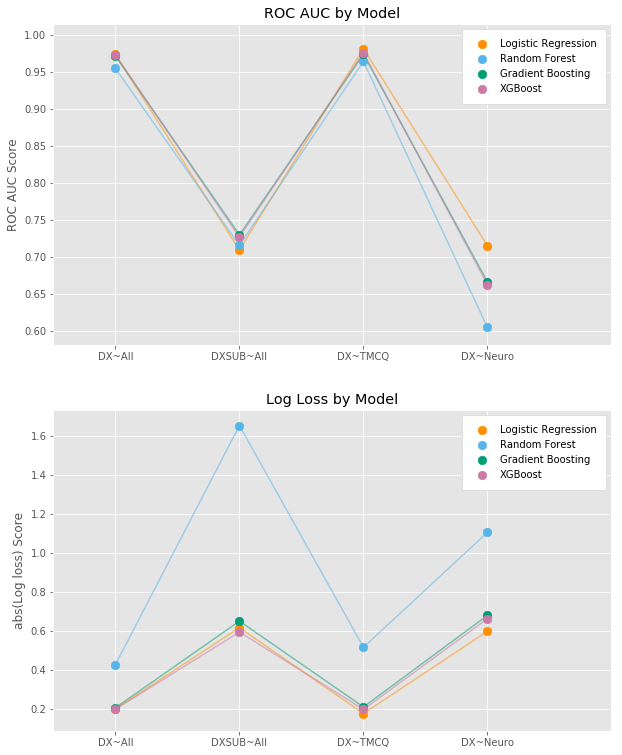

In [4]:
fig, axs = plt.subplots(2,1, figsize=(10,13))
_ = create_metric_graph(model_dict, metric_dict, axs)

Recall:
 * Higher ROC AUC score == **Better** Performance
 * Higher abs(Log Loss) score == **Worse** Performance
 
We can conclude a few things from these graphs:
 * Random Forest has the worst performance in terms of log loss
 * The datasets DX~All and DX~TMCQ have good general performance, across models. The models have a harder time predicting DXSUB~All and DX~Neuro.

## Significance of Differences

There seems to be some difference in models, but we need to see if it's statistically significant. To do this, I ran Mann-Whitney U tests combination of model metric within a dataset to see if the differences were statistically significant. I used Benjamini-Hochberg FDR control to deal with the problem of multiple testing. The FDR is set at 0.05. I picked this method over the Bonferroni correction because I didn't see the need for as stringent a control that the Bonferonni provides.

In [33]:
DX_all = pd.read_csv('final_csvs/DX_All.csv')
DXSUB_all = pd.read_csv('final_csvs/DXSUB_All.csv')
DX_tmcq = pd.read_csv('final_csvs/DX_TMCQ.csv')
DX_neuro = pd.read_csv('final_csvs/DX_Neuro.csv')

In [38]:
run_mannwhitneyu_all(DX_all)

,p-val,rank,(i/m)Q,sig?
RandomForest_ROCAUC_GradientBoosting_ROCAUC,0.070083,1,0.004167,False
LogReg_ROCAUC_RandomForest_ROCAUC,0.070233,2,0.008333,False
RandomForest_ROCAUC_XGB_ROCAUC,0.075387,3,0.012500,False
LogReg_LogLoss_RandomForest_LogLoss,0.136518,4,0.016667,False
RandomForest_LogLoss_GradientBoosting_LogLoss,0.153745,5,0.020833,False
RandomForest_LogLoss_XGB_LogLoss,0.172352,6,0.025000,False
LogReg_LogLoss_GradientBoosting_LogLoss,0.285375,7,0.029167,False
GradientBoosting_LogLoss_XGB_LogLoss,0.285375,8,0.033333,False
LogReg_ROCAUC_XGB_ROCAUC,0.425053,9,0.037500,False
LogReg_ROCAUC_GradientBoosting_ROCAUC,0.454827,10,0.041667,False


In [39]:
run_mannwhitneyu_all(DXSUB_all)

,p-val,rank,(i/m)Q,sig?
LogReg_LogLoss_RandomForest_LogLoss,0.000091,1,0.004167,True
RandomForest_LogLoss_GradientBoosting_LogLoss,0.000091,2,0.008333,True
RandomForest_LogLoss_XGB_LogLoss,0.000091,3,0.012500,True
LogReg_ROCAUC_XGB_ROCAUC,0.060612,4,0.016667,False
LogReg_ROCAUC_GradientBoosting_ROCAUC,0.080986,5,0.020833,False
RandomForest_ROCAUC_XGB_ROCAUC,0.136518,6,0.025000,False
GradientBoosting_LogLoss_XGB_LogLoss,0.136518,7,0.029167,False
LogReg_LogLoss_XGB_LogLoss,0.192337,8,0.033333,False
RandomForest_ROCAUC_GradientBoosting_ROCAUC,0.202751,9,0.037500,False
LogReg_LogLoss_GradientBoosting_LogLoss,0.213678,10,0.041667,False


Random Forest had significantly worse log loss than all the other models on this dataset.

In [40]:
run_mannwhitneyu_all(DX_tmcq)

,p-val,rank,(i/m)Q,sig?
LogReg_ROCAUC_RandomForest_ROCAUC,0.070233,1,0.004167,False
LogReg_LogLoss_RandomForest_LogLoss,0.070233,2,0.008333,False
LogReg_LogLoss_GradientBoosting_LogLoss,0.070233,3,0.012500,False
LogReg_LogLoss_XGB_LogLoss,0.106147,4,0.016667,False
RandomForest_ROCAUC_XGB_ROCAUC,0.144778,5,0.020833,False
LogReg_ROCAUC_GradientBoosting_ROCAUC,0.153745,6,0.025000,False
LogReg_ROCAUC_XGB_ROCAUC,0.213417,7,0.029167,False
RandomForest_LogLoss_XGB_LogLoss,0.213678,8,0.033333,False
RandomForest_ROCAUC_GradientBoosting_ROCAUC,0.224761,9,0.037500,False
RandomForest_LogLoss_GradientBoosting_LogLoss,0.260261,10,0.041667,False


In [41]:
run_mannwhitneyu_all(DX_neuro)

,p-val,rank,(i/m)Q,sig?
LogReg_LogLoss_RandomForest_LogLoss,0.002293,1,0.004167,True
LogReg_ROCAUC_RandomForest_ROCAUC,0.007010,2,0.008333,True
RandomForest_LogLoss_GradientBoosting_LogLoss,0.044487,3,0.012500,False
LogReg_ROCAUC_XGB_ROCAUC,0.052055,4,0.016667,False
RandomForest_ROCAUC_GradientBoosting_ROCAUC,0.052055,5,0.020833,False
LogReg_LogLoss_GradientBoosting_LogLoss,0.052055,6,0.025000,False
LogReg_LogLoss_XGB_LogLoss,0.052055,7,0.029167,False
RandomForest_ROCAUC_XGB_ROCAUC,0.060612,8,0.033333,False
RandomForest_LogLoss_XGB_LogLoss,0.070233,9,0.037500,False
LogReg_ROCAUC_GradientBoosting_ROCAUC,0.106147,10,0.041667,False


Random Forest had significantly worse LogLoss and ROCAUC when compared to Logistic Regression.

So, all the models are on the same page (with exception of Random Forest in the DXSUB_All and DX_Neuro dataset). We can conclude that it'd be sufficient to perform logistic regression on each dataset.

---

# Tuning the Models

Prior to running the statistical tests, I decided to try tuning the XGBoost model since it seemed to be the best model. I now know that the models are not significantly different in performance, and a logistic regression is sufficient. 

For details on parameter tuning for XGBoost, check out `scratch/Tuning XGBoost.ipynb`.

# Testing on the Holdout Set

I wanted to check the ROC AUC scores and log loss of the datasets when trained on the training data and tested on the hold-out set.

In [17]:
holdout_roc_auc = pd.read_csv('final_csvs/holdout_metrics_ROC.csv', index_col=0)
holdout_log_loss = pd.read_csv('final_csvs/holdout_metrics_logloss.csv', index_col=0)

holdout_model_dict = {
              'Logistic Regression': {'name': 'LogReg', 'linestyle': 'solid', 'marker': 'o', 'color':'#ff9000'},
              'Random Forest': {'name': 'RandomForest', 'linestyle': 'solid', 'marker': 'o', 'color':'#56B4E9'},
              'Gradient Boosting': {'name': 'GradientBoosting', 'linestyle': 'solid', 'marker': 'o', 'color':'#009E73'},
              'XGBoost': {'name': 'XGB', 'linestyle': 'solid', 'marker': 'o', 'color':'#CC79A7'}
              }

holdout_metric_dict = {
                'ROC_AUC':
                    {'Title': 'ROC AUC by Model',
                     'ylabel': 'ROC AUC Score',
                     'dataframe': holdout_roc_auc,
                     'col_names': ['DX~All', 'DXSUB~All', 'DX~TMCQ', 'DX~Neuro']},
                'LogLoss':
                    {'Title': 'Log Loss by Model',
                     'ylabel': 'abs(Log loss) Score',
                     'dataframe': holdout_log_loss,
                     'col_names': ['DX~All', 'DXSUB~All', 'DX~TMCQ', 'DX~Neuro']},
               }

roc_auc = pd.read_csv('final_csvs/ROC_AUC.csv', index_col=0)
log_loss = pd.read_csv('final_csvs/Log_Loss.csv', index_col=0)

model_dict = {
              'Logistic Regression_CV': {'name': 'LogReg', 'linestyle': 'dashed', 'marker': '^', 'color':'#ff9000'},
              'Random Forest_CV': {'name': 'RandomForest', 'linestyle': 'dashed', 'marker': '^', 'color':'#56B4E9'},
              'Gradient Boosting_CV': {'name': 'GradientBoosting', 'linestyle': 'dashed', 'marker': '^', 'color':'#009E73'},
              'XGBoost_CV': {'name': 'XGB', 'linestyle': 'dashed', 'marker': '^', 'color':'#CC79A7'}
              }

metric_dict = {
                'ROC_AUC':
                    {'Title': 'ROC AUC by Model',
                     'ylabel': 'ROC AUC Score',
                     'dataframe': roc_auc,
                     'col_names': ['DX~All', 'DXSUB~All', 'DX~TMCQ', 'DX~Neuro']},
                'LogLoss':
                    {'Title': 'Log Loss by Model',
                     'ylabel': 'abs(Log loss) Score',
                     'dataframe': -log_loss,
                     'col_names': ['DX~All', 'DXSUB~All', 'DX~TMCQ', 'DX~Neuro']},
               }

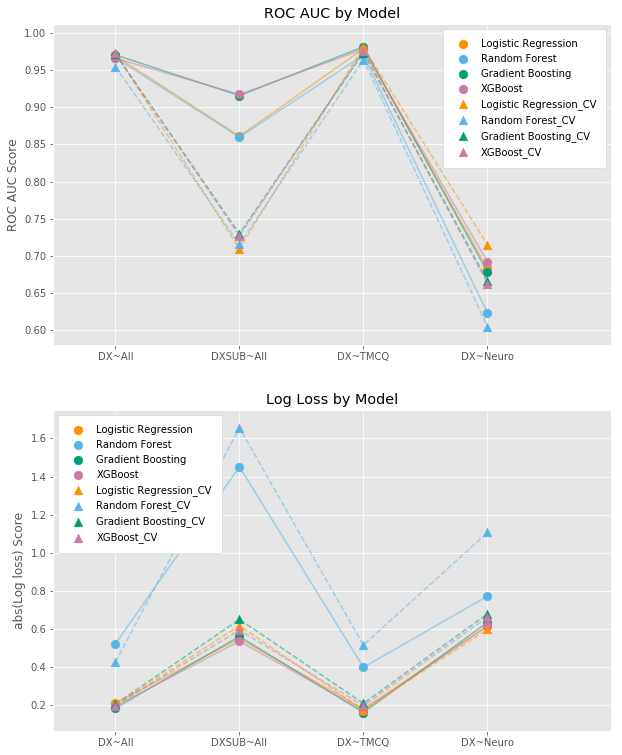

In [18]:
fig, axs = plt.subplots(2,1, figsize=(10,13))
_ = create_metric_graph(holdout_model_dict, holdout_metric_dict, axs)
_ = create_metric_graph(model_dict, metric_dict, axs)

It seems like cross-validated metric scores were a little worse than when trained on the entire training set and tested on the holdout set, but it still followed a similar pattern.